# Comparing Ketamine and Midazolam after treatment in ROIs
- focus on end of treatment
- Amygdala
- vmPFC
- Hippocampus

In [1]:
# import relevant packages
import glob
import numpy as np
import scipy
import nilearn
import nilearn.image
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
import dask
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
# Set session
ses = 3
## Grab group
# compare between groups

medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')
scr_id = medication_cond.scr_id
func_files = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses%s/modelfit/_subject_id_*/modelestimate/results/cope7.nii.gz' %(ses))
#func_files = glob.glob('/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/allScript_ses%s/modelfit_ses_%s/_subject_id_*/modelestimate/mapflow/_modelestimate0/results/cope2.nii.gz' %(ses, ses))

func_files.sort()
func_files

['/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_008/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_1223/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_1263/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_1293/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_1307/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_1322/modelestimate/results/cope7.nii.gz',
 '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subj

In [23]:
scr_id

0      KPE008
1     KPE1223
2     KPE1253
3     KPE1263
4     KPE1293
5     KPE1307
6     KPE1315
7     KPE1322
8     KPE1339
9     KPE1343
10    KPE1351
11    KPE1356
12    KPE1364
13    KPE1369
14    KPE1387
15    KPE1390
16    KPE1403
17    KPE1419
18    KPE1464
19    KPE1468
20    KPE1480
21    KPE1499
22    KPE1561
23    KPE1573
24    KPE1578
Name: scr_id, dtype: object

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


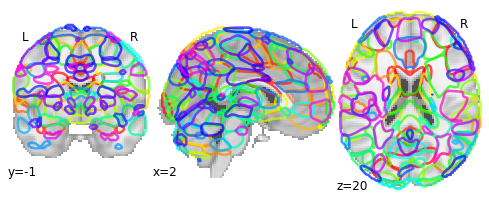

In [7]:
maps_img = '/media/Data/work/DiFuMo_atlas/256/maps.nii.gz'
labels = pd.read_csv('/media/Data/work/DiFuMo_atlas/256/labels_256_dictionary.csv')
#coords = nilearn.plotting.find_parcellation_cut_coords(labels_img=maps_img)
#coords = nilearn.plotting.find_probabilistic_atlas_cut_coords(maps_img)
# plot atlas (only if we want)
nilearn.plotting.plot_prob_atlas(maps_img, draw_cross=False)

In [24]:
masker = nilearn.input_data.NiftiMapsMasker(maps_img=maps_img, 
                                            verbose=2, standardize=True).fit()

[NiftiMapsMasker.fit] loading regions from /media/Data/work/DiFuMo_atlas/256/maps.nii.gz


In [35]:
t_maps3 = masker.transform(func_files)

[NiftiMapsMasker.transform_single_imgs] Loading data from [/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/fsl_analysis_ses3/modelfit/_subject_id_008/modelestimate/results/cope7.nii.gz, /media/Data/Lab_Projects/KPE_PTSD_Project/neuroimagin
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals


In [10]:
t_maps2.shape

(24, 256)

In [26]:
# extract relevant ROIs (vmpfc, hippo, amygdala)
labels_list = list(labels.Difumo_names)
amg = labels_list.index('Amygdala')
hippo_post = labels_list.index('Hippocampus posterior')
hippo_ant = labels_list.index('Hippocampus anterior')
vmPFC_ant = labels_list.index('Ventromedial prefrontal cortex anterior')
vmPFC = labels_list.index('Ventromedial prefrontal cortex')
index_list = np.array([amg, hippo_post, hippo_ant, vmPFC_ant, vmPFC])

In [27]:
ses1_ROIs = t_maps1[: ,index_list]
ses1_ROIs.shape

(25, 5)

In [36]:
ses3_ROIs = t_maps3[: ,index_list]
ses3_ROIs.shape

(20, 5)

In [12]:
ses2_ROIs = t_maps2[: ,index_list]
ses2_ROIs.shape

(24, 5)

In [13]:
df = pd.DataFrame({'scr_id': scr_id[0:24], 'amg': ses2_ROIs[:,0], 'hippopost': ses2_ROIs[:,1], 
                  'hippoAnt': ses2_ROIs[:,2], 'vmPFC_ant': ses2_ROIs[:,3], 'vmPFC': ses2_ROIs[:,4]})
df = pd.merge(medication_cond, df)
df = df.rename(columns={'med_cond': 'group'})
df = df.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})
df

,scr_id,group,amg,hippopost,hippoAnt,vmPFC_ant,vmPFC
0,KPE008,ketamine,-0.465222,-0.688774,0.538616,0.337328,0.128000
1,KPE1223,ketamine,0.856679,0.521909,0.613998,0.774375,0.589104
2,KPE1253,midazolam,1.023002,-0.386011,-0.834792,-1.172510,1.470069
3,KPE1263,midazolam,0.603694,-0.506558,0.763601,0.746135,0.560564
4,KPE1293,ketamine,-0.553164,-0.309508,-0.397273,0.297633,-0.358259
5,KPE1307,ketamine,-2.318977,-0.597950,-0.118689,-0.990741,-1.934913
6,KPE1315,ketamine,0.194892,0.001936,-0.115215,0.253506,0.504973
7,KPE1322,ketamine,0.299361,1.267163,0.492407,1.540114,1.670747
8,KPE1339,ketamine,-0.516204,-0.003874,0.518529,0.939097,-0.079983
9,KPE1343,ketamine,-2.330085,-0.823191,-1.347205,-0.524386,0.089253


Ttest_indResult(statistic=-1.4180515886707268, pvalue=0.17018571435391172)

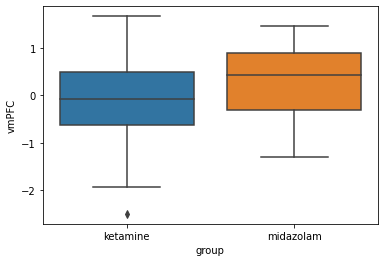

In [21]:
sns.boxplot(y='vmPFC',x= 'group',data=df)
scipy.stats.ttest_ind(df.vmPFC[df.group=="ketamine"], df.vmPFC[df.group=='midazolam'])

In [ ]:
sns.boxplot(y='amg',x= 'group',data=df)
scipy.stats.ttest_ind(df.amg[df.group=="ketamine"], df.amg[df.group=='midazolam'])

In [28]:
df1 = pd.DataFrame({'scr_id': scr_id, 'amg1': ses1_ROIs[:,0], 'hippopost1': ses1_ROIs[:,1], 
                  'hippoAnt1': ses1_ROIs[:,2], 'vmPFC_ant1': ses1_ROIs[:,3],
                   'vmPFC1': ses1_ROIs[:,4]})
df1 = pd.merge(medication_cond, df1)
df1 = df1.rename(columns={'med_cond': 'group'})
df1 = df1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})
df1

,scr_id,group,amg1,hippopost1,hippoAnt1,vmPFC_ant1,vmPFC1
0,KPE008,ketamine,0.900702,0.130818,1.415508,0.131255,0.722584
1,KPE1223,ketamine,-0.000383,0.077618,-0.772821,0.575779,0.384614
2,KPE1253,midazolam,-0.022806,0.185740,-0.794891,0.294901,-0.295044
3,KPE1263,midazolam,-0.821198,-1.733423,-1.369823,-0.584887,-0.734617
4,KPE1293,ketamine,-0.579605,0.040720,0.967307,-0.050851,0.375149
5,KPE1307,ketamine,-2.235922,-0.646215,0.460168,-1.842212,-1.463576
6,KPE1315,ketamine,0.015740,-0.469739,-0.366420,-0.984387,-0.386665
7,KPE1322,ketamine,0.669743,2.348803,1.245576,2.698468,1.399117
8,KPE1339,ketamine,0.629622,-0.045620,-1.649392,-0.590417,-0.581334
9,KPE1343,ketamine,-1.827200,-2.167584,-0.802191,-1.813836,-2.091250


In [29]:
col = df.loc[: , ["hippoAnt","hippopost"]]
df['hippAvg'] = col.mean(axis=1)

dfTot = pd.merge(df, df1)
dfTot['amg2_1'] = dfTot.amg - dfTot.amg1
dfTot['hippost2_1'] = dfTot.hippopost - dfTot.hippopost1
dfTot['hippAnt2_1'] = dfTot.hippoAnt - dfTot.hippoAnt1
dfTot

,scr_id,group,amg,hippopost,hippoAnt,vmPFC_ant,vmPFC,hippAvg,amg1,hippopost1,hippoAnt1,vmPFC_ant1,vmPFC1,amg2_1,hippost2_1,hippAnt2_1
0,KPE008,ketamine,-0.465222,-0.688774,0.538616,0.337328,0.128000,-0.075079,0.900702,0.130818,1.415508,0.131255,0.722584,-1.365924,-0.819593,-0.876891
1,KPE1223,ketamine,0.856679,0.521909,0.613998,0.774375,0.589104,0.567954,-0.000383,0.077618,-0.772821,0.575779,0.384614,0.857062,0.444292,1.386819
2,KPE1253,midazolam,1.023002,-0.386011,-0.834792,-1.172510,1.470069,-0.610401,-0.022806,0.185740,-0.794891,0.294901,-0.295044,1.045808,-0.571751,-0.039900
3,KPE1263,midazolam,0.603694,-0.506558,0.763601,0.746135,0.560564,0.128521,-0.821198,-1.733423,-1.369823,-0.584887,-0.734617,1.424892,1.226865,2.133425
4,KPE1293,ketamine,-0.553164,-0.309508,-0.397273,0.297633,-0.358259,-0.353390,-0.579605,0.040720,0.967307,-0.050851,0.375149,0.026441,-0.350228,-1.364580
5,KPE1307,ketamine,-2.318977,-0.597950,-0.118689,-0.990741,-1.934913,-0.358319,-2.235922,-0.646215,0.460168,-1.842212,-1.463576,-0.083055,0.048266,-0.578857
6,KPE1315,ketamine,0.194892,0.001936,-0.115215,0.253506,0.504973,-0.056640,0.015740,-0.469739,-0.366420,-0.984387,-0.386665,0.179152,0.471675,0.251204
7,KPE1322,ketamine,0.299361,1.267163,0.492407,1.540114,1.670747,0.879785,0.669743,2.348803,1.245576,2.698468,1.399117,-0.370382,-1.081640,-0.753169
8,KPE1339,ketamine,-0.516204,-0.003874,0.518529,0.939097,-0.079983,0.257328,0.629622,-0.045620,-1.649392,-0.590417,-0.581334,-1.145826,0.041747,2.167922
9,KPE1343,ketamine,-2.330085,-0.823191,-1.347205,-0.524386,0.089253,-1.085198,-1.827200,-2.167584,-0.802191,-1.813836,-2.091250,-0.502884,1.344393,-0.545014


In [14]:
sns.boxplot(x='group',y='amg1', data=dfTot, saturation=.4)
scipy.stats.ttest_ind(dfTot.amg2_1[dfTot['group']=='ketamine'],
                      dfTot['amg2_1'][dfTot['group']=='midazolam'])

NameError: name 'dfTot' is not defined

Ttest_indResult(statistic=-2.8974675362889157, pvalue=0.008353808055991145)

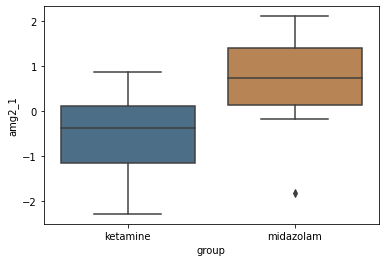

In [32]:
sns.boxplot(x='group',y='amg2_1', data=dfTot, saturation=.4)
scipy.stats.ttest_ind(dfTot.amg2_1[dfTot['group']=='ketamine'],
                      dfTot['amg2_1'][dfTot['group']=='midazolam'])

In [ ]:
df.groupby(['group']).count()

Ttest_indResult(statistic=-3.502808955912397, pvalue=0.002010504076813303)

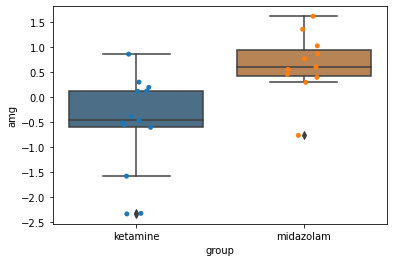

In [33]:
# plot
sns.boxplot(x='group',y='amg', data=df, saturation=.4)
sns.stripplot(x='group',y='amg', data=df)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df.amg[df['group']=='ketamine'], df['amg'][df['group']=='midazolam'])

Ttest_indResult(statistic=0.3937659771165316, pvalue=0.6975443224592655)

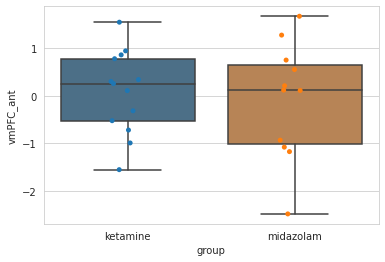

In [58]:
sns.boxplot(x='group',y='vmPFC_ant', data=df, saturation=.4)
sns.stripplot(x='group',y='vmPFC_ant', data=df)
#sns.boxplot(x='group',y='meanAct', data=df)
scipy.stats.ttest_ind(df.vmPFC_ant[df['group']=='ketamine'], df['vmPFC_ant'][df['group']=='midazolam'])

In [37]:
## add session 3
df3 = pd.DataFrame({'scr_id': scr_id, 'amg': ses3_ROIs[:,0], 'hippopost': ses3_ROIs[:,1], 
                  'hippoAnt': ses3_ROIs[:,2], 'vmPFC_ant': ses3_ROIs[:,3], 'vmPFC': ses3_ROIs[:,4]})
df3 = pd.merge(medication_cond, df3)
df3 = df3.rename(columns={'med_cond': 'group'})
df3 = df3.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})
df3

ValueError: array length 20 does not match index length 25

## Use PyMC3 for bayesian based analysis 

In [ ]:
import pymc3 as pm
# first code new variable for group index (1=ketamine, 2= midazolam)
group = {'ketamine': 1,'midazolam': 2} 
df['groupIdx'] =[group[item] for item in df.group] 

In [ ]:
#az.summary(posterior_1, credible_interval=.95).round(2) # adding round to make shorted floats
pm.summary(posterior_1)#, alpha=.05).round(2)# also possible

In [ ]:
# play with glm module of pymc3
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('amg ~ groupIdx', df)
    trace = pm.sample(draws=4000, tune=3000)

In [ ]:
pm.summary(trace, credible_interval=.95).round(2)

In [ ]:
sns.distplot(trace.groupIdx)
sum(trace['groupIdx']>0) / len(trace['groupIdx'])

In [ ]:
## Presenting differences between the groups using scatter plot for each group + 
## The resulting Bayesian analyses plots (density of differences and boxplot)

sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
grid = plt.GridSpec(2, 20, wspace=.1, hspace=0.0) # building a grid to put the graphs in
plt.subplot(grid[:, :10])
#fig.add_subplot(grid[0,0])
g1= sns.stripplot(x='group',y='meanAct',hue = 'group', data=df, s=8)
#g1 = sns.boxplot(x='group',y='meanAct',hue = 'group', data=df)
g1.set_ylim(-80,80)
g1.legend_.remove()

plt.subplot(grid[:, 10])
g3 = sns.boxplot(trace.groupIdx, orient='v')
g3.set_ylim(-80,80)
g3.set_yticks([])

plt.subplot(grid[:, 11:13])
g2 = sns.distplot(trace.groupIdx, vertical=True, color="Green")
g2.set_ylim(-80,80)
#g2.set_yticks([])
g2.yaxis.tick_right()

In [ ]:
#df_vmpfc = pd.DataFrame({'scr_id': scr_id, 'meanAct': mean_act})
#df['vmPFC'] = mean_act_vmpfc
#sns.boxplot(x='group',y='vmPFC', data=df)
sns.barplot(x='group',y='vmPFC', data=df, ci=68)
scipy.stats.ttest_ind(df.vmPFC[df['group']=='ketamine'], df['vmPFC'][df['group']=='midazolam'])

In [ ]:
len(mean_act_vmpfc)

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('vmPFC ~ groupIdx', df)
    trace_vmpfc = pm.sample(draws=4000, tune=3000)

In [ ]:
pm.summary(trace_vmpfc, credible_interval=.95).round(2)

In [ ]:
## Hippocampus
mask_file = '/media/Data/work/KPE_ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=15", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, verbose=5)

In [ ]:
mean_act_hippo = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_hippo.append(average)


In [ ]:
df['hippo'] = mean_act_hippo
sns.barplot(x='group',y='hippo', data=df, ci=68)
scipy.stats.ttest_ind(df.hippo[df['group']=='ketamine'], df['hippo'][df['group']=='midazolam'])

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('hippo ~ groupIdx', df)
    trace_hippo = pm.sample(draws=2000, tune=5000)
pm.summary(trace_hippo, credible_interval=.95).round(2)

In [ ]:
sns.set_style("whitegrid")

grid = plt.GridSpec(2, 20, wspace=.1, hspace=0.0) # building a grid to put the graphs in
plt.subplot(grid[:, :10])
#fig.add_subplot(grid[0,0])
g1= sns.stripplot(x='group',y='hippo',hue = 'group', data=df, s=8)
#g1 = sns.boxplot(x='group',y='meanAct',hue = 'group', data=df)
g1.set_ylim(-80,80)
g1.legend_.remove()

plt.subplot(grid[:, 10])
g3 = sns.boxplot(trace_hippo.groupIdx, orient='v')
g3.set_ylim(-80,80)
g3.set_yticks([])

plt.subplot(grid[:, 11:13])
g2 = sns.distplot(trace_hippo.groupIdx, vertical=True, color="Green")
g2.set_ylim(-80,80)
#g2.set_yticks([])
g2.yaxis.tick_right()

## Caudate

In [ ]:
mask_file = '/media/Data/work/caudate_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=12", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, verbose=5)

In [ ]:
mean_act_st = []
scr_id = []
for func in func_files:
    # get subject number
    scr_id.append('KPE' + func.split('id_')[1].split('/')[0])
    # get average activation
    t_map = masker.fit_transform(func)
    
    average = np.mean(np.array(t_map))
    mean_act_st.append(average)


In [ ]:
df['striatumAc'] = mean_act_st
sns.barplot(x='group',y='striatumAc', data=df, ci=68)
scipy.stats.ttest_ind(df.striatumAc[df['group']=='ketamine'], df['striatumAc'][df['group']=='midazolam'])

In [ ]:
with pm.Model() as model_glm:
    GLM.from_formula('striatumAc ~ groupIdx', df)
    trace_striat = pm.sample()
pm.summary(trace_striat, credible_interval=.95).round(2)

# Correlation between PCL scores and average activation

In [ ]:
## read pcl scores
pclDf = pd.read_csv('/home/or/Documents/kpe_analyses/KPEIHR0009_DATA_2019-10-07_1121.csv')
# take only KPE patients
pclDf = pclDf[pclDf['scr_id'].str.startswith('KPE')]
list(pclDf.columns)

In [ ]:
dfP = pd.DataFrame({'subject': pclDf['scr_id']})
dfP_PCL = pclDf[['scr_id','redcap_event_name','pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7',
 'pcl5_8', 'pcl5_9', 'pcl5_10', 'pcl5_11', 'pcl5_12', 'pcl5_13', 'pcl5_14', 'pcl5_15', 'pcl5_16', 'pcl5_17',
 'pcl5_18', 'pcl5_19', 'pcl5_20']]
# remove NAs
dfP_PCL = dfP_PCL.dropna()
# set list of columns for analysis
colList = list(dfP_PCL)
colList.remove('scr_id')
colList.remove('redcap_event_name')
# set total pcl scores 
dfP_PCL['pclTotal'] = dfP_PCL[colList].sum(axis=1)
sns.distplot(dfP_PCL.pclTotal)

In [ ]:
# reshape it to wide
df2=dfP_PCL.pivot(index = 'scr_id',columns='redcap_event_name', values='pclTotal')
list(df2)
df2 = df2.rename(columns={"30_day_follow_up_s_arm_1": "30Days", "90_day_follow_up_s_arm_1": "90Days",
                    "screening_selfrepo_arm_1": "Screening", "visit_1_arm_1": "Visit1", 
                    "visit_7_week_follo_arm_1": "Visit7"})
#df2['scr_id'] = dfP_PCL['scr_id']
df2

In [ ]:
# merging two data frames toghether
dfTest = pd.merge(df, df2, on = 'scr_id')
# change visit1 missing values with screening values
for i in dfTest.iterrows():
    if np.isnan(i[1].Visit1):
        print("Nan")
        print(i[1].Screening)
        dfTest.at[i[0], 'Visit1']= i[1].Screening

# create difference pcl score
dfTest['days30_1'] = dfTest['30Days'] - dfTest.Visit1
dfTest['days30_s'] = dfTest['30Days'] - dfTest.Screening
dfTest['Visit7_1'] = dfTest['Visit7'] - dfTest.Visit1
dfTest

In [ ]:
sns.lmplot(x='Visit7', y='meanAct',hue='group', data=dfTest)
xMask = np.isnan(dfTest['Visit7'])
yMask = np.isnan(dfTest['meanAct'])
nas = np.logical_or(xMask, yMask)
scipy.stats.pearsonr(dfTest['Visit7'][~nas],dfTest['meanAct'][~nas])

In [ ]:
## Test difference in amygdala activation between 1st and2nd session and see if it correlates to symtpoms
dfTest['amg_ses2_ses1'] = dfTest.meanAct - df_ses1.meanAct_ses1

In [ ]:
sns.lmplot(x='amg_ses2_ses1', y='Visit7_1',hue='group', data=dfTest)
xMask = np.isnan(dfTest['Visit7_1'])
yMask = np.isnan(dfTest['amg_ses2_ses1'])
nas = np.logical_or(xMask, yMask)
scipy.stats.pearsonr(dfTest['Visit7_1'][~nas],dfTest['amg_ses2_ses1'][~nas])

In [ ]:
### So - change in Hippocampus reactivation to trauma script (vs. relax) is correlated to changes symptoms at end of treatment
       

In [ ]:
dfTest

In [ ]:
# lets test correlation per group (although this is a very ver


In [ ]:
dfTest.corr()
#sns.heatmap(dfTest)

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(dfTest[dfTest.group==0].corr(), annot=True, cmap="coolwarm")

In [ ]:

X = dfTest[['meanAct','hippo', 'group']]
y = dfTest['days30_1']

X = sm.add_constant(X)
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

In [ ]:
smOLS = smf.ols(formula='days30_1 ~ group * meanAct', data=dfTest).fit()

smOLS.summary()

## Check correlation with SCR

In [ ]:
scr = pd.read_csv('/home/or/kpe_task_analysis/scr_deltas.csv')
scr1 = scr.drop(columns = ['med_cond', 'groupIdx'])
scr1

In [ ]:
dfMerge = pd.merge(df, scr1)
dfMerge

In [ ]:
sns.lmplot(x = 'Trauma_2vs1', y= 'meanAct',hue = 'group', data=dfMerge)

In [ ]:
smOLS = smf.ols(formula='Trauma_2vs1 ~ group * meanAct', data=dfMerge).fit()

smOLS.summary()

## Check changes in amg activation and SCR / PCL

In [ ]:
dfMerge['amg_2_1'] = dfMerge.meanAct - df_ses1.meanAct_ses1

In [ ]:
sns.lmplot(x='Trauma_2vs1', y = 'amg_2_1', hue='group', data=dfMerge)